## 1) Loading Data and Packages + Util

In [1]:
import os
from google.colab import files
import shutil

import math
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing_extensions import final
import seaborn as sns
import random

from collections import OrderedDict

Load data from local folder

In [2]:
os.makedirs('/content/data', exist_ok=True)
destination_folder = '/content/data'
uploaded = files.upload()
for filename in uploaded.keys():
    shutil.move(filename, os.path.join(destination_folder, filename))

Saving full_fb_data.csv to full_fb_data.csv


Setup fitbit_data

In [54]:
full_fb_data = pd.read_csv('/content/data/full_fb_data.csv')

In [55]:
survey_features = ['diet', 'medication', 'symptoms']
rm_features = ['avgWeight_per_day', 'calories', 'heart', 'steps', 'hrv_dailyRmssd', 'hrv_deepRmssd', 'spo2_avg', 'temp/skin_nightlyRelative']
z_features = ['avgWeight_per_day_rm', 'calories_rm', 'heart_rm', 'steps_rm', 'hrv_dailyRmssd_rm', 'hrv_deepRmssd_rm', 'spo2_avg_rm', 'temp/skin_nightlyRelative_rm']

In [56]:
# Sort by date
full_fb_data['date'] = pd.to_datetime(full_fb_data['date'])
full_fb_data = full_fb_data.sort_values(by=['fitbit_user_id', 'date'])

# Shift survey columns
for col in survey_features:
  full_fb_data[col] = full_fb_data.groupby('fitbit_user_id')[col].shift(-1)

# Set remaining nan visit columns to 0
full_fb_data['visit_day'] = full_fb_data['visit_day'].fillna(0)

# Create has_visit column
full_fb_data['has_visit'] = 0
for user_id, group in full_fb_data.groupby('fitbit_user_id'):
    if group['visit_day'].sum() != 0:
        full_fb_data.loc[group.index, 'has_visit'] = 1

In [74]:
def extract_days_before_visit(df):
    output_rows = []
    seq_id = 0

    for user_id, group in df.groupby('fitbit_user_id'):
        group = group.reset_index(drop=True)
        visit_indices = group.index[group['visit_day'] == 1].tolist()

        if not visit_indices:
            continue  # Skip users with no visits

        first_visit_idx = visit_indices[0]
        visit_day = group.loc[first_visit_idx, 'days']

        # Include all days ≤ visit day
        pre_visit_data = group[group['days'] <= visit_day].copy()

        # Add relative day to visit
        pre_visit_data['days_to_visit'] = pre_visit_data['days'] - visit_day
        pre_visit_data['fitbit_user_id'] = user_id
        pre_visit_data['sequence_id'] = seq_id
        seq_id += 1

        output_rows.append(pre_visit_data)

    result_df = pd.concat(output_rows, axis=0).reset_index(drop=True)

    return result_df

In [17]:
visit_df = extract_days_before_visit(full_fb_data)
no_visit_df = full_fb_data[full_fb_data['has_visit'] == 0]

In [18]:
def rolling_mean(df, features, window_size = 3):
    df = df.copy()

    for feature in features:
        df[f'{feature}_rm'] = df.groupby('fitbit_user_id')[feature].rolling(window=window_size).mean().reset_index(0, drop=True)

    return df

In [19]:
visit_df = rolling_mean(visit_df, rm_features)
no_visit_df = rolling_mean(no_visit_df, rm_features)

In [21]:
def zscore_rolling(df, features, bootstrap_n=3):
    df_z = df.copy()

    for col in features:
        df_z[col + '_z'] = np.nan

        for user_id, group in df.groupby('fitbit_user_id'):
            series = group[col]
            z = []
            past_vals = []

            # First phase: collect the first 3 non-NaN values
            idxs = series.index.tolist()
            collected = 0

            for idx in idxs:
                val = series.loc[idx]

                if pd.isna(val):
                    z.append(np.nan)
                else:
                    past_vals.append(val)
                    collected += 1
                    z.append(None)  # placeholder to be replaced later

                if collected == bootstrap_n:
                    break

            # If we got enough to bootstrap, calculate mean/std and assign z-scores
            if len(past_vals) == bootstrap_n:
                mean = np.mean(past_vals)
                std = np.std(past_vals, ddof=1)
                z_vals = [(v - mean) / std if std > 0 else 0 for v in past_vals]

                # Replace placeholders
                for i in range(len(z)):
                    if z[i] is None:
                        z[i] = z_vals.pop(0)

            # Continue with the rest
            for idx in idxs[len(z):]:
                val = series.loc[idx]

                if pd.isna(val):
                    z.append(np.nan)
                    continue

                past_vals.append(val)
                mean = np.mean(past_vals)
                std = np.std(past_vals, ddof=1)
                z_val = (val - mean) / std if std > 0 else 0
                z.append(z_val)

            df_z.loc[series.index, col + '_z'] = z

    return df_z

In [24]:
visit_df = zscore_rolling(visit_df, z_features)
no_visit_df = zscore_rolling(no_visit_df, z_features)

/tmp/ipython-input-21-1259931419.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, None, None, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan

In [27]:
def extract_3wk_no_visits(df, window_days=22, max_windows=3, seed=123):
    np.random.seed(seed)
    output_rows = []

    for user_id, group in df.groupby('fitbit_user_id'):
        group = group.reset_index(drop=True)

        min_day = group['days'].min()
        max_day = group['days'].max()

        possible_starts = list(range(min_day, max_day - window_days + 1))
        np.random.shuffle(possible_starts)

        windows_added = 0

        for start in possible_starts:
            end = start + window_days
            window = group[(group['days'] >= start) & (group['days'] < end)].copy()

            if len(window) == window_days:  # Complete window
                window['days_to_window'] = window['days'] - end + 1
                window['fitbit_user_id'] = user_id
                output_rows.append(window)
                windows_added += 1

            if windows_added >= max_windows:
                break

    return pd.concat(output_rows, axis=0).reset_index(drop=True)

In [75]:
def extract_3wk_random_visits(df, window_days=22, max_windows=4, days_before=21, exclude_window_before_visit=False, seed=123):
    np.random.seed(seed)
    output_rows = []

    # Group by user first
    for user_id, user_group in df.groupby('fitbit_user_id'):
      valid_windows = []

      # Check each sequence for valid windows
      for seq_id, seq_group in user_group.groupby('sequence_id'):
        seq_group = seq_group.sort_values('days').reset_index(drop=True)
        days_in_seq = seq_group['days'].values

        first_visit_day = days_in_seq.max()

        if exclude_window_before_visit:
          max_end_day = first_visit_day - days_before
        else:
          max_end_day = first_visit_day

        # Go through all possible start days in this sequence
        for i in range(len(days_in_seq)):
          start_day = days_in_seq[i]
          end_day = start_day + window_days - 1

          if start_day > max_end_day:
            continue

            # Check if the full window is contained in the sequence
          if np.all(np.isin(np.arange(start_day, end_day + 1), days_in_seq)):
            valid_windows.append((seq_id, start_day))

      # Shuffle and select up to max_windows
      np.random.shuffle(valid_windows)
      selected_windows = valid_windows[:max_windows]

      for seq_id, start_day in selected_windows:
        group = df[(df['fitbit_user_id'] == user_id) & (df['sequence_id'] == seq_id)]
        end_day = start_day + window_days

        window = group[(group['days'] >= start_day) & (group['days'] < end_day)].copy()

        if len(window) == window_days:
          window['days_to_window'] = window['days'] - (end_day - 1)
          window['fitbit_user_id'] = user_id
          window['sequence_id'] = seq_id
          output_rows.append(window)

    if output_rows:
      return pd.concat(output_rows, axis=0).reset_index(drop=True)
    else:
      return pd.DataFrame(columns=df.columns.tolist() + ['days_to_window'])


In [43]:
visit_3wk = visit_df[visit_df['days_to_visit'] >= -21]
no_visit_3wk = extract_3wk_no_visits(no_visit_df)
random_visit_3wk = extract_3wk_random_visits(visit_df)

In [44]:
visit_3wk.to_csv('/content/data/visit_3wk.csv', index=False)
no_visit_3wk.to_csv('/content/data/no_visit_3wk.csv', index=False)
random_visit_3wk.to_csv('/content/data/random_visit_3wk.csv', index=False)

files.download('/content/data/visit_3wk.csv')
files.download('/content/data/no_visit_3wk.csv')
files.download('/content/data/random_visit_3wk.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 2a) Graphing Functions

In [26]:
def drop_nan_user(df, feature):
    valid_users = df.groupby('fitbit_user_id')[feature].apply(lambda x: not x.isna().all())
    valid_user_ids = valid_users[valid_users].index

    return df[df['fitbit_user_id'].isin(valid_user_ids)].reset_index(drop=True)

In [45]:
def plot_feature_comparison(df1, df2, feature, time_col1='days_to_visit', time_col2='days_to_window', label1='Visit Users', label2='No-Visit Users', bin_continuous=False, n_bins=10):
    # ------------------- Line Plot -------------------
    fig, ax = plt.subplots(figsize=(12, 6))

    # Group by time and compute mean + std
    grouped1 = df1.groupby(time_col1)[feature]
    avg1 = grouped1.mean()
    std1 = grouped1.std()

    grouped2 = df2.groupby(time_col2)[feature]
    avg2 = grouped2.mean()
    std2 = grouped2.std()

    x1 = avg1.index.values
    y1 = avg1.values.astype(float)
    std1_vals = std1.reindex(avg1.index).fillna(0).values.astype(float)

    x2 = avg2.index.values
    y2 = avg2.values.astype(float)
    std2_vals = std2.reindex(avg2.index).fillna(0).values.astype(float)

    # Plot
    ax.plot(x1, y1, marker='o', label=label1)
    ax.fill_between(x1, y1 - std1_vals, y1 + std1_vals, alpha=0.2)

    ax.plot(x2, y2, marker='o', label=label2)
    ax.fill_between(x2, y2 - std2_vals, y2 + std2_vals, alpha=0.2)

    ax.set_title(f"Average {feature} Over Time")
    ax.set_xlabel("Days")
    ax.set_ylabel(f"Average {feature}")
    ax.axvline(0, color='red', linestyle='--', label='Event Day')
    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    plt.show()

     # ------------------- Helper to prepare bar plot data -------------------
    def prepare_for_stacked(df, tcol):
        df = df.copy()
        if bin_continuous:
            df[feature] = df[feature].apply(lambda x: 'Missing' if pd.isna(x) else 'Non-missing')
        else:
            df[feature] = df[feature].fillna('Missing').astype(str)
        return df.groupby([tcol, feature]).size().unstack(fill_value=0)

    ct1 = prepare_for_stacked(df1, time_col1)
    ct2 = prepare_for_stacked(df2, time_col2)

    # ------------------- Stacked Bar Plot (Counts) -------------------
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    ct1.plot(kind='bar', stacked=True, ax=axs[0])
    axs[0].set_title(f"{feature} by {time_col1} ({label1}) - Counts")
    axs[0].set_xlabel(time_col1)
    axs[0].set_ylabel("Count")

    ct2.plot(kind='bar', stacked=True, ax=axs[1])
    axs[1].set_title(f"{feature} by {time_col2} ({label2}) - Counts")
    axs[1].set_xlabel(time_col2)
    axs[1].set_ylabel("Count")
    plt.tight_layout()
    plt.show()

    # ------------------- Stacked Bar Plot (Percentages) -------------------
    pct1 = ct1.div(ct1.sum(axis=1), axis=0).fillna(0)
    pct2 = ct2.div(ct2.sum(axis=1), axis=0).fillna(0)

    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    pct1.plot(kind='bar', stacked=True, ax=axs[0])
    axs[0].set_title(f"{feature} by {time_col1} ({label1}) - Percentages")
    axs[0].set_xlabel(time_col1)
    axs[0].set_ylabel("Proportion")

    pct2.plot(kind='bar', stacked=True, ax=axs[1])
    axs[1].set_title(f"{feature} by {time_col2} ({label2}) - Percentages")
    axs[1].set_xlabel(time_col2)
    axs[1].set_ylabel("Proportion")

    plt.tight_layout()
    plt.show()

In [46]:
def plot_feature_comparison_3(df1, df2, df3, feature, time_col1='days_to_visit', time_col2='days_to_window', time_col3='days_to_window', label1='Visit Users', label2='No-Visit Users', label3='Random Visit Users', bin_continuous=False, n_bins=10):
    # ------------------- Line Plot -------------------
    fig, ax = plt.subplots(figsize=(18, 6))

    # Group by time and compute mean# Group by time and compute mean + std
    grouped1 = df1.groupby(time_col1)[feature]
    avg1 = grouped1.mean()
    std1 = grouped1.std()

    grouped2 = df2.groupby(time_col2)[feature]
    avg2 = grouped2.mean()
    std2 = grouped2.std()

    grouped3 = df3.groupby(time_col3)[feature]
    avg3 = grouped3.mean()
    std3 = grouped3.std()

    x1 = avg1.index.values
    y1 = avg1.values.astype(float)
    std1_vals = std1.reindex(avg1.index).fillna(0).values.astype(float)

    x2 = avg2.index.values
    y2 = avg2.values.astype(float)
    std2_vals = std2.reindex(avg2.index).fillna(0).values.astype(float)

    x3 = avg3.index.values
    y3 = avg3.values.astype(float)
    std3_vals = std3.reindex(avg3.index).fillna(0).values.astype(float)

    # Plot
    ax.plot(x1, y1, marker='o', label=label1)
    ax.fill_between(x1, y1 - std1_vals, y1 + std1_vals, alpha=0.2)

    ax.plot(x2, y2, marker='o', label=label2)
    ax.fill_between(x2, y2 - std2_vals, y2 + std2_vals, alpha=0.2)

    ax.plot(x3, y3, marker='o', label=label3)
    ax.fill_between(x3, y3 - std3_vals, y3 + std3_vals, alpha=0.2)

    ax.set_title(f"Average {feature} Over Time")
    ax.set_xlabel("Days")
    ax.set_ylabel(f"Average {feature}")
    ax.axvline(0, color='red', linestyle='--', label='Event Day')
    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    plt.show()

     # ------------------- Helper to prepare bar plot data -------------------
    def prepare_for_stacked(df, tcol):
        df = df.copy()
        if bin_continuous:
            df[feature] = df[feature].apply(lambda x: 'Missing' if pd.isna(x) else 'Non-missing')
        else:
            df[feature] = df[feature].fillna('Missing').astype(str)
        return df.groupby([tcol, feature]).size().unstack(fill_value=0)

    ct1 = prepare_for_stacked(df1, time_col1)
    ct2 = prepare_for_stacked(df2, time_col2)
    ct3 = prepare_for_stacked(df3, time_col3)

    # ------------------- Stacked Bar Plot (Counts) -------------------
    fig, axs = plt.subplots(1, 3, figsize=(18, 3))
    ct1.plot(kind='bar', stacked=True, ax=axs[0])
    axs[0].set_title(f"{feature} by {time_col1} ({label1}) - Counts")
    axs[0].set_xlabel(time_col1)
    axs[0].set_ylabel("Count")

    ct2.plot(kind='bar', stacked=True, ax=axs[1])
    axs[1].set_title(f"{feature} by {time_col2} ({label2}) - Counts")
    axs[1].set_xlabel(time_col2)
    axs[1].set_ylabel("Count")

    ct3.plot(kind='bar', stacked=True, ax=axs[2])
    axs[2].set_title(f"{feature} by {time_col3} ({label3}) - Counts")
    axs[2].set_xlabel(time_col3)
    axs[2].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

    # ------------------- Stacked Bar Plot (Percentages) -------------------
    pct1 = ct1.div(ct1.sum(axis=1), axis=0).fillna(0)
    pct2 = ct2.div(ct2.sum(axis=1), axis=0).fillna(0)
    pct3 = ct3.div(ct3.sum(axis=1), axis=0).fillna(0)

    fig, axs = plt.subplots(1, 3, figsize=(18, 3))
    pct1.plot(kind='bar', stacked=True, ax=axs[0])
    axs[0].set_title(f"{feature} by {time_col1} ({label1}) - Percentages")
    axs[0].set_xlabel(time_col1)
    axs[0].set_ylabel("Proportion")

    pct2.plot(kind='bar', stacked=True, ax=axs[1])
    axs[1].set_title(f"{feature} by {time_col2} ({label2}) - Percentages")
    axs[1].set_xlabel(time_col2)
    axs[1].set_ylabel("Proportion")

    pct3.plot(kind='bar', stacked=True, ax=axs[2])
    axs[2].set_title(f"{feature} by {time_col3} ({label3}) - Percentages")
    axs[2].set_xlabel(time_col3)
    axs[2].set_ylabel("Proportion")

    plt.tight_layout()
    plt.show()

## 2b) Graphing

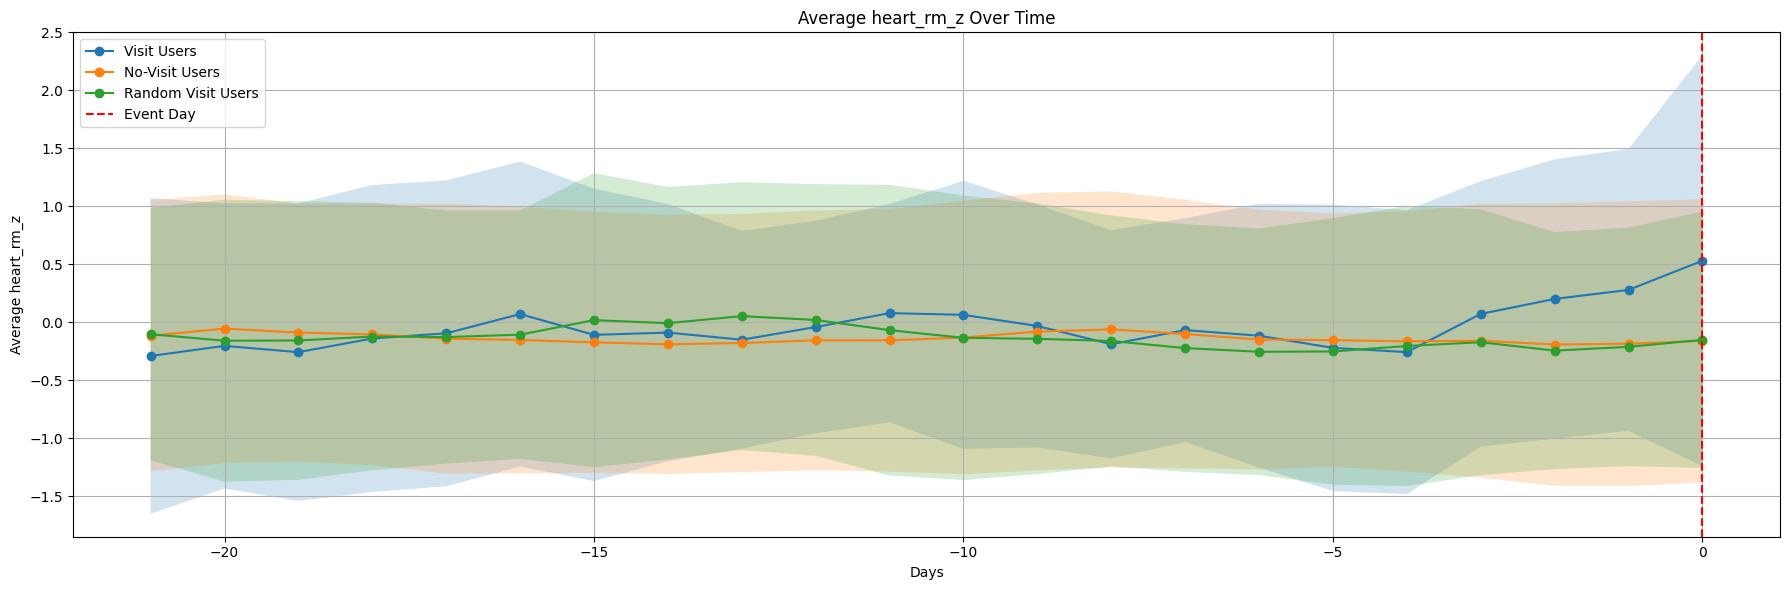

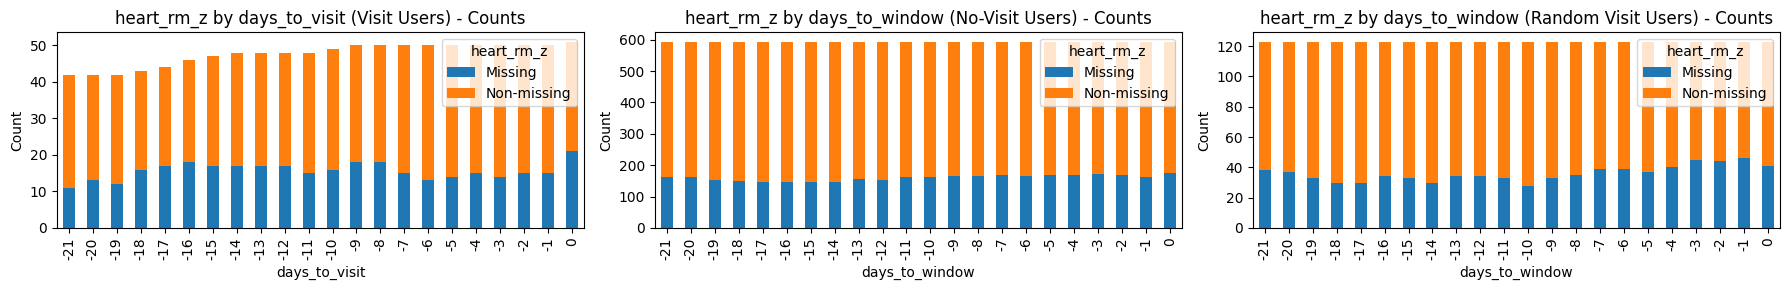

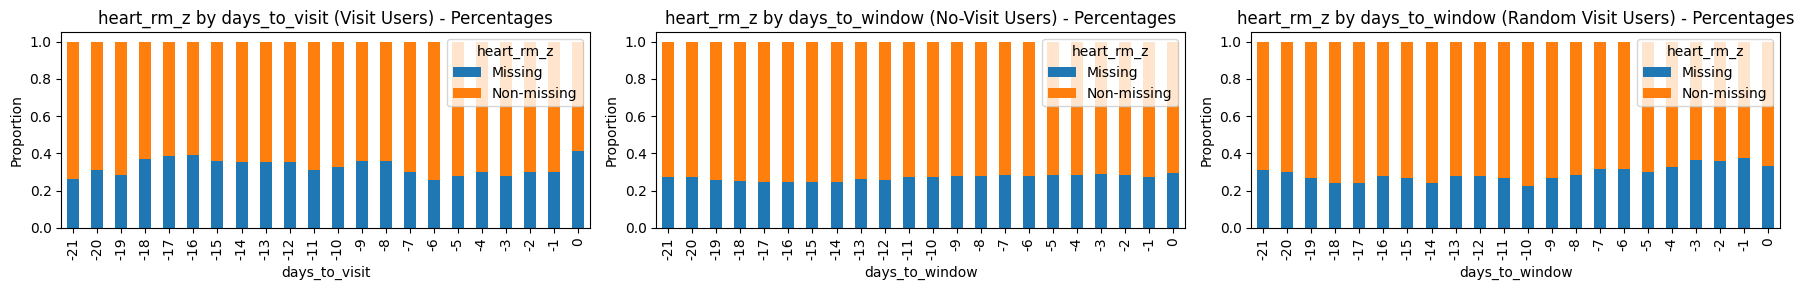

In [48]:
plot_feature_comparison_3(visit_3wk, no_visit_3wk, random_visit_3wk, 'heart_rm_z', bin_continuous=True)

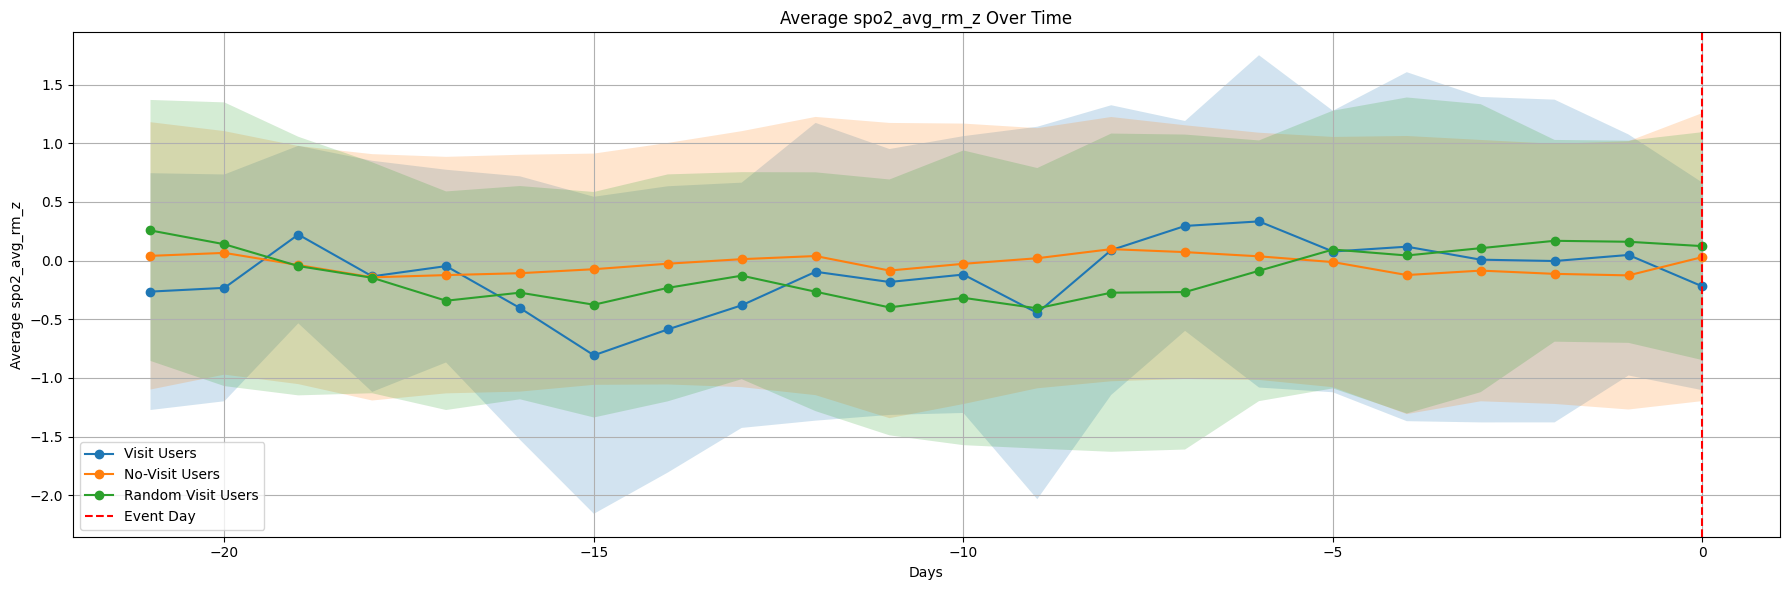

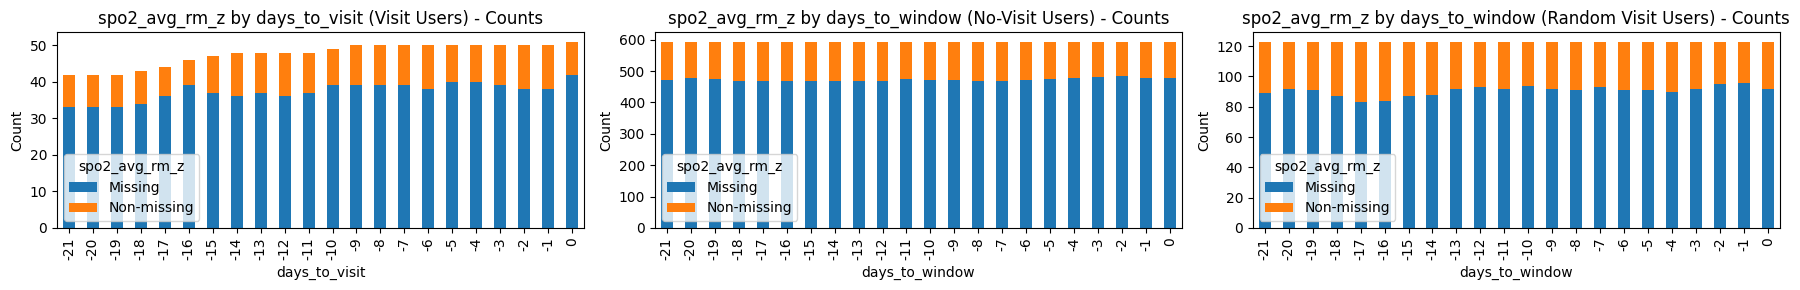

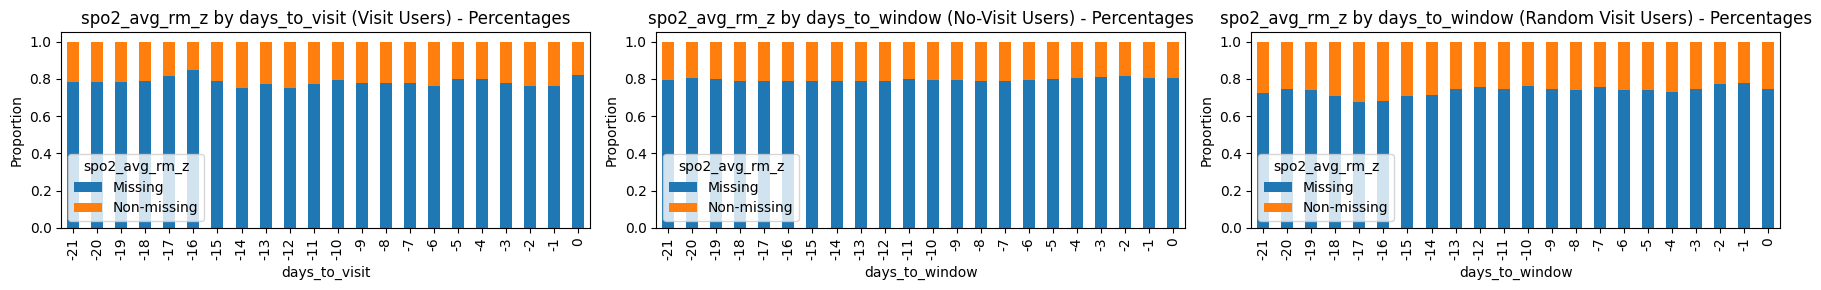

In [49]:
plot_feature_comparison_3(visit_3wk, no_visit_3wk, random_visit_3wk, 'spo2_avg_rm_z', bin_continuous=True)

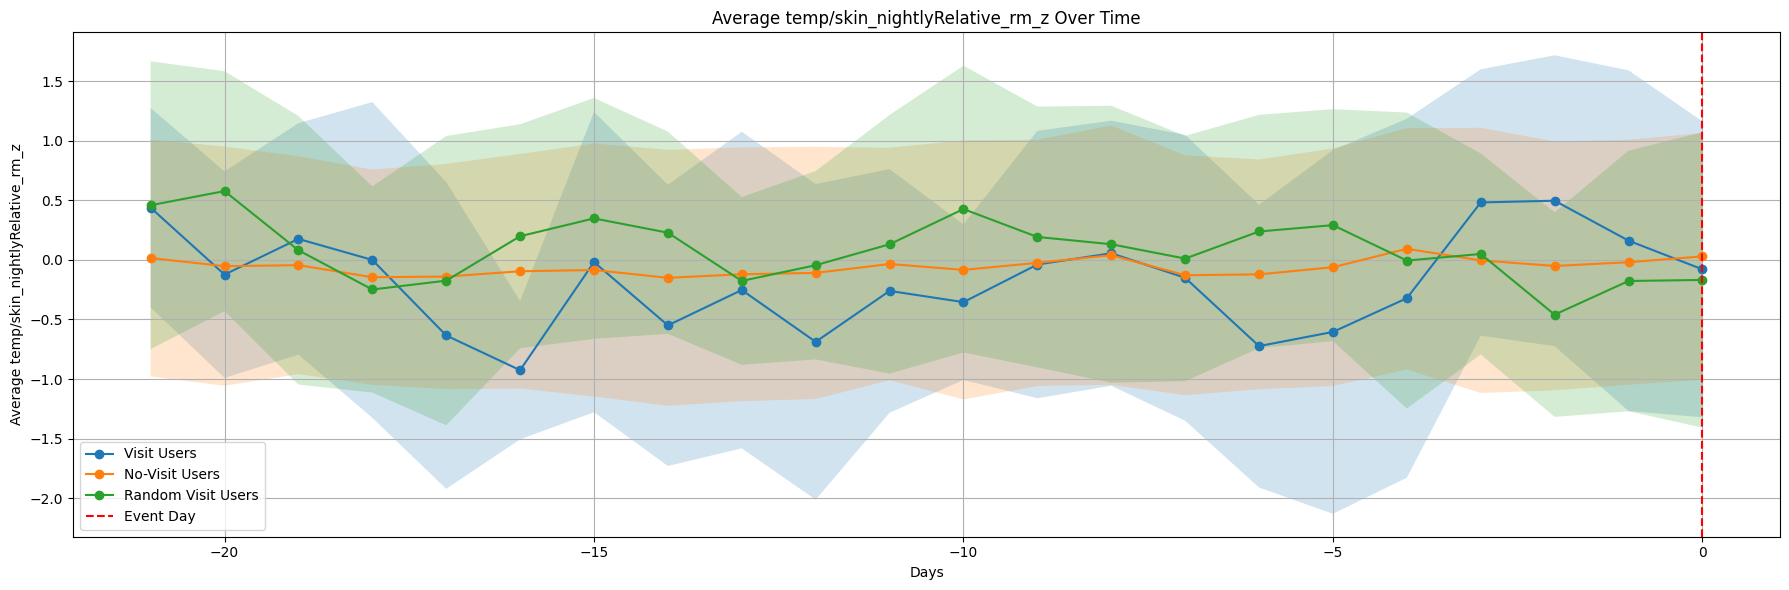

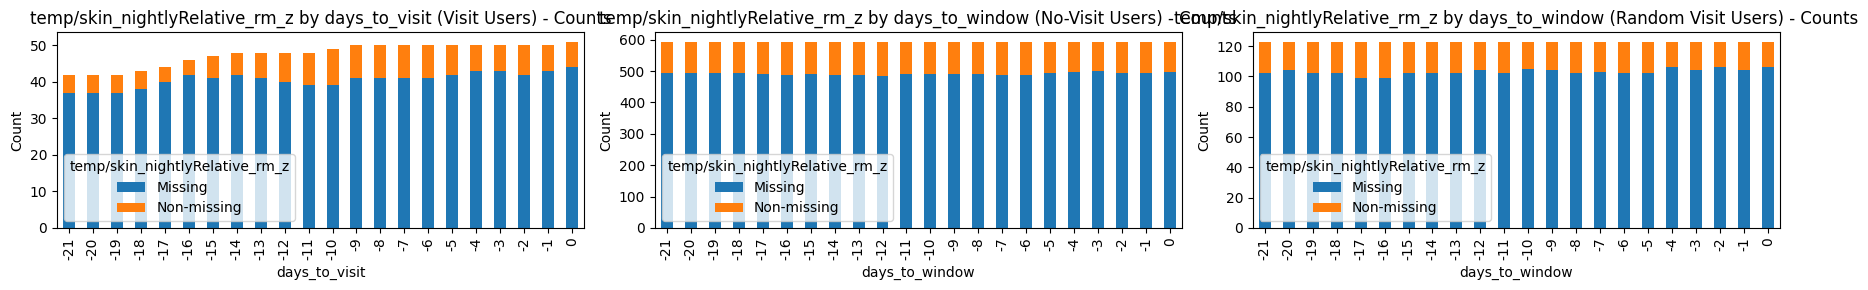

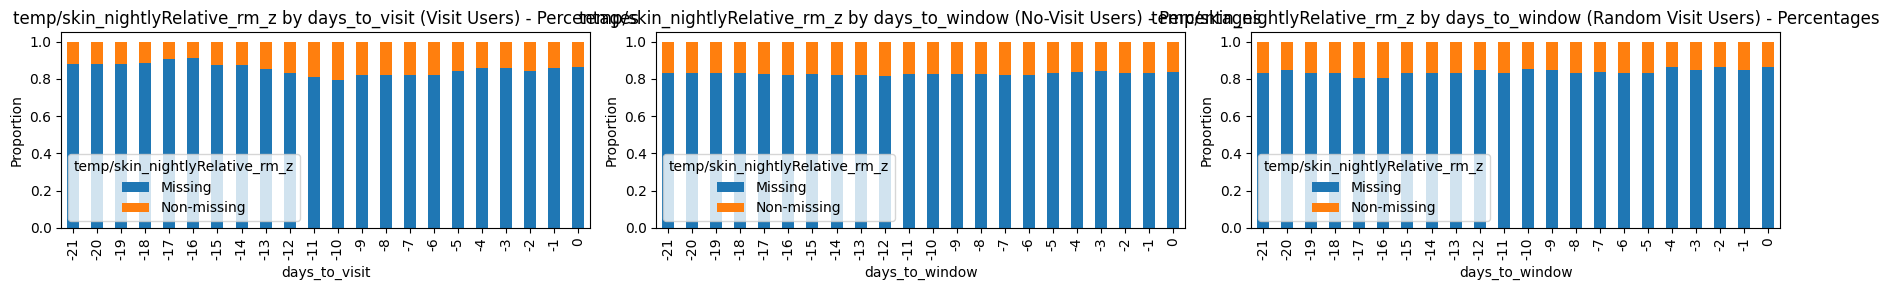

In [50]:
plot_feature_comparison_3(visit_3wk, no_visit_3wk, random_visit_3wk, 'temp/skin_nightlyRelative_rm_z', bin_continuous=True)

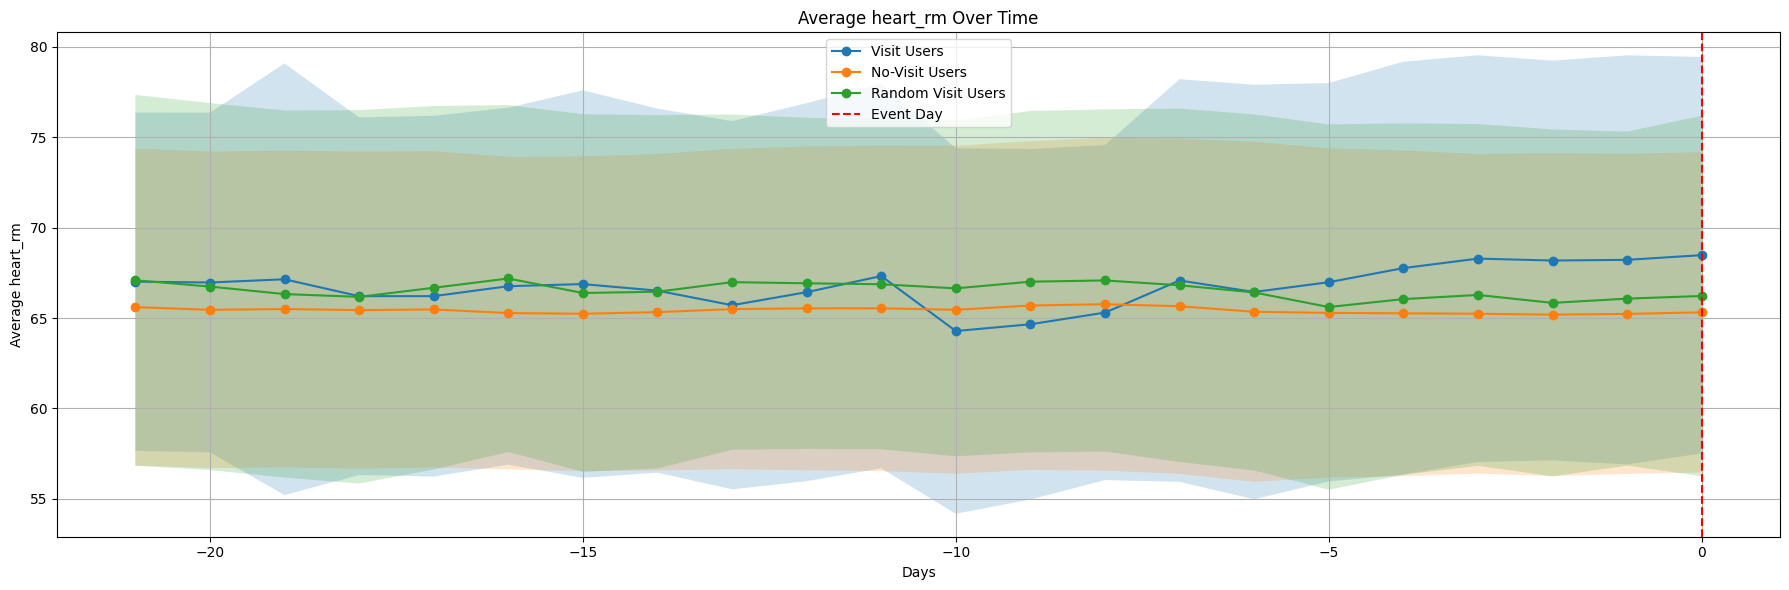

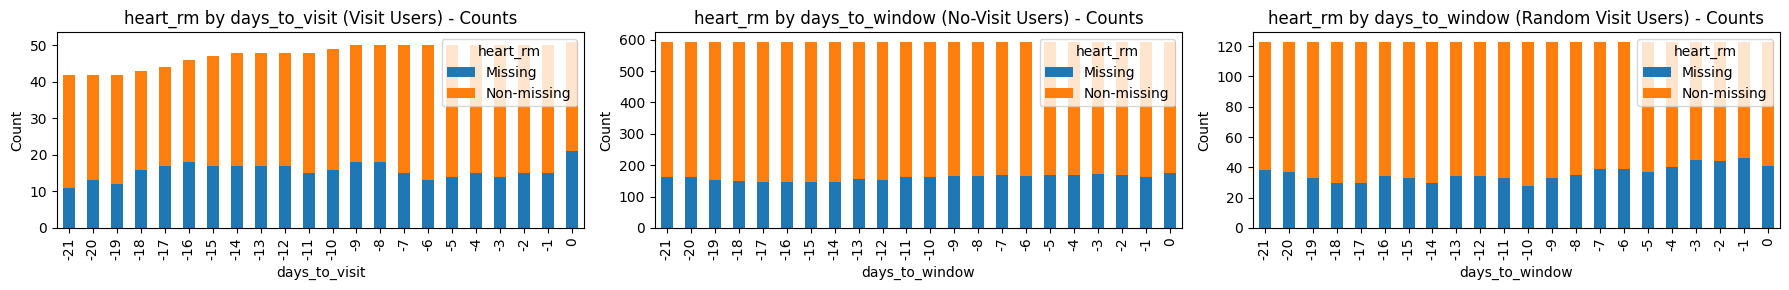

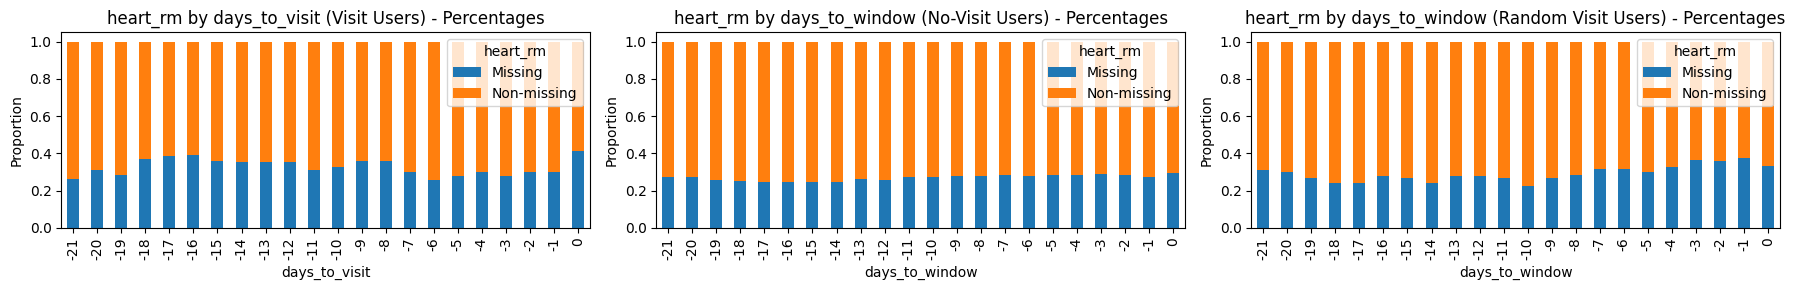

In [51]:
plot_feature_comparison_3(visit_3wk, no_visit_3wk, random_visit_3wk, 'heart_rm', bin_continuous=True)

## 3) Looking at users with multiple visits

In [57]:
visit_df = full_fb_data[full_fb_data['has_visit'] == 1]

In [60]:
multi_visit_users = []
for user_id, group in visit_df.groupby('fitbit_user_id'):
  visits = group['visit_day'].sum()
  if visits > 1:
    multi_visit_users.append(user_id)
    print(f"User {user_id} has {visits} visits.")

User 7 has 7.0 visits.
User 28 has 2.0 visits.
User 49 has 3.0 visits.
User 88 has 2.0 visits.
User 105 has 4.0 visits.
User 117 has 2.0 visits.
User 151 has 3.0 visits.
User 181 has 2.0 visits.
User 198 has 4.0 visits.
User 221 has 2.0 visits.
User 227 has 3.0 visits.
User 250 has 2.0 visits.
User 264 has 2.0 visits.
User 267 has 2.0 visits.
User 270 has 2.0 visits.
User 272 has 2.0 visits.
User 284 has 2.0 visits.


In [61]:
for user_id, group in visit_df.groupby('fitbit_user_id'):
  if user_id in multi_visit_users:
    print(f"User: {user_id}")
    visit_indices = group.index[group['visit_day'] == 1].tolist()
    for i in range(len(visit_indices) - 1):
      gap = visit_indices[i+1] - visit_indices[i]
      print(f"Gap between index {visit_indices[i]} and {visit_indices[i+1]}: {gap}")

User: 7
Gap between index 921 and 950: 29
Gap between index 950 and 959: 9
Gap between index 959 and 991: 32
Gap between index 991 and 1020: 29
Gap between index 1020 and 1030: 10
Gap between index 1030 and 1058: 28
User: 28
Gap between index 3614 and 3681: 67
User: 49
Gap between index 6363 and 6391: 28
Gap between index 6391 and 6430: 39
User: 88
Gap between index 12648 and 12748: 100
User: 105
Gap between index 15490 and 15510: 20
Gap between index 15510 and 15538: 28
Gap between index 15538 and 15591: 53
User: 117
Gap between index 17423 and 17437: 14
User: 151
Gap between index 22191 and 22196: 5
Gap between index 22196 and 22282: 86
User: 181
Gap between index 27082 and 27112: 30
User: 198
Gap between index 29908 and 29919: 11
Gap between index 29919 and 30012: 93
Gap between index 30012 and 30056: 44
User: 221
Gap between index 33316 and 33450: 134
User: 227
Gap between index 34090 and 34120: 30
Gap between index 34120 and 34153: 33
User: 250
Gap between index 36751 and 36797: 4

In [62]:
multiv_df = rolling_mean(full_fb_data, rm_features)
multiv_df = zscore_rolling(multiv_df, z_features)

/tmp/ipython-input-21-1259931419.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan, nan, None, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [71]:
def extract_days_before_visit_multi(df, min_gap = 28):
    output_rows = []
    seq_id = 0

    for user_id, group in df.groupby('fitbit_user_id'):
        group = group.reset_index(drop=True)
        visit_indices = group.index[group['visit_day'] == 1].tolist()

        if not visit_indices:
            continue  # Skip users with no visits

        first_visit_idx = visit_indices[0]
        visit_day = group.loc[first_visit_idx, 'days']

        # Include all days ≤ visit day
        pre_visit_data = group[group['days'] <= visit_day].copy()

        # Add relative day to visit
        pre_visit_data['days_to_visit'] = pre_visit_data['days'] - visit_day
        pre_visit_data['fitbit_user_id'] = user_id
        pre_visit_data['sequence_id'] = seq_id
        seq_id += 1

        output_rows.append(pre_visit_data)

        if len(visit_indices) > 1:
          for i in range(len(visit_indices) - 1):

            gap = visit_indices[i+1] - visit_indices[i]
            prev_visit_day = group.loc[visit_indices[i], 'days']

            if gap >= min_gap:

              next_visit_idx = visit_indices[i+1]
              visit_day = group.loc[next_visit_idx, 'days']

              # Include all days ≤ visit day
              pre_visit_data = group[(group['days'] > prev_visit_day) & (group['days'] <= visit_day)].copy()

              # Add relative day to visit
              pre_visit_data['days_to_visit'] = pre_visit_data['days'] - visit_day
              pre_visit_data['fitbit_user_id'] = user_id
              pre_visit_data['sequence_id'] = seq_id
              seq_id += 1

              output_rows.append(pre_visit_data)

    result_df = pd.concat(output_rows, axis=0).reset_index(drop=True)

    return result_df

In [72]:
visit_df = extract_days_before_visit_multi(multiv_df)
no_visit_df = multiv_df[multiv_df['has_visit'] == 0]

In [73]:
visit_df.to_csv('/content/data/visit_df.csv', index=False)
files.download('/content/data/visit_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [76]:
visit_3wk = visit_df[visit_df['days_to_visit'] >= -21]
no_visit_3wk = extract_3wk_no_visits(no_visit_df)
random_visit_3wk = extract_3wk_random_visits(visit_df)

In [77]:
visit_3wk.to_csv('/content/data/visit_3wk.csv', index=False)
no_visit_3wk.to_csv('/content/data/no_visit_3wk.csv', index=False)
random_visit_3wk.to_csv('/content/data/random_visit_3wk.csv', index=False)

files.download('/content/data/visit_3wk.csv')
files.download('/content/data/no_visit_3wk.csv')
files.download('/content/data/random_visit_3wk.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

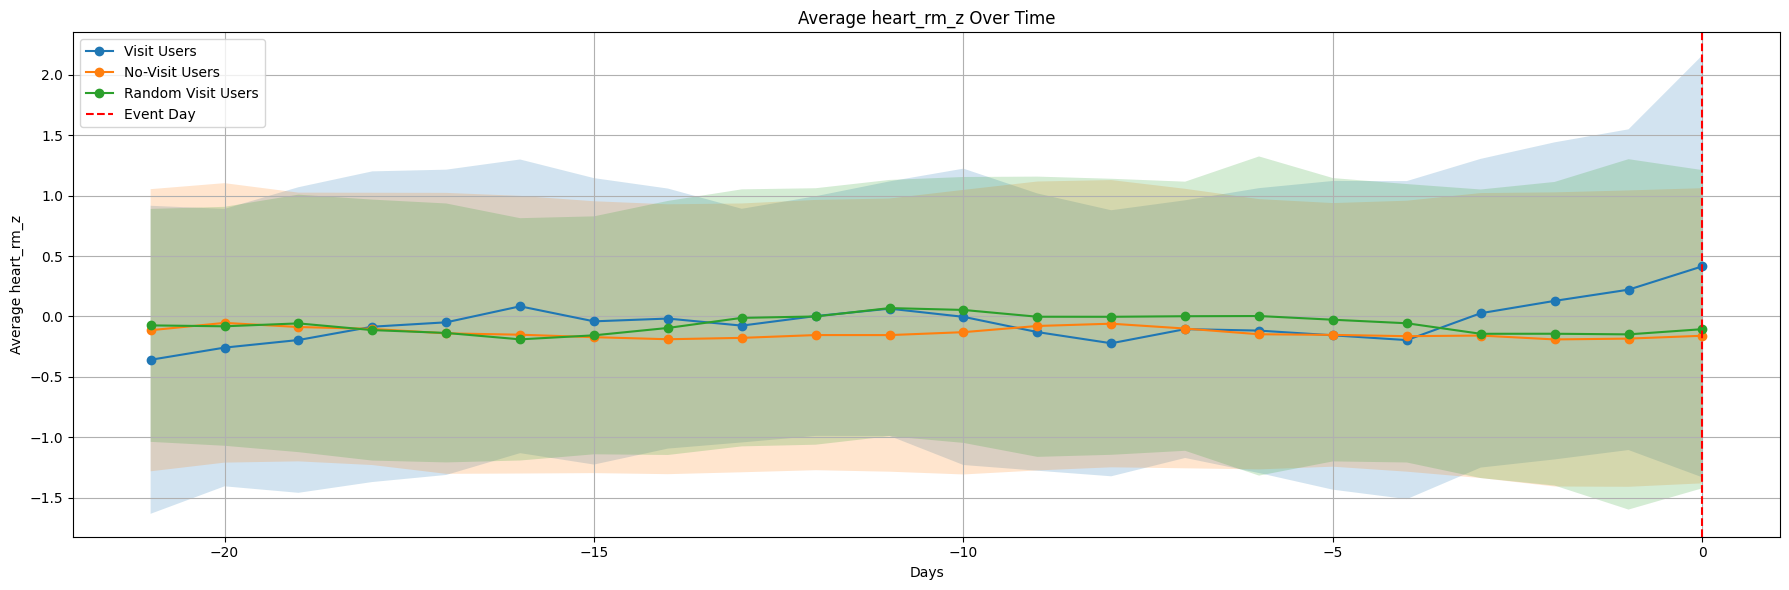

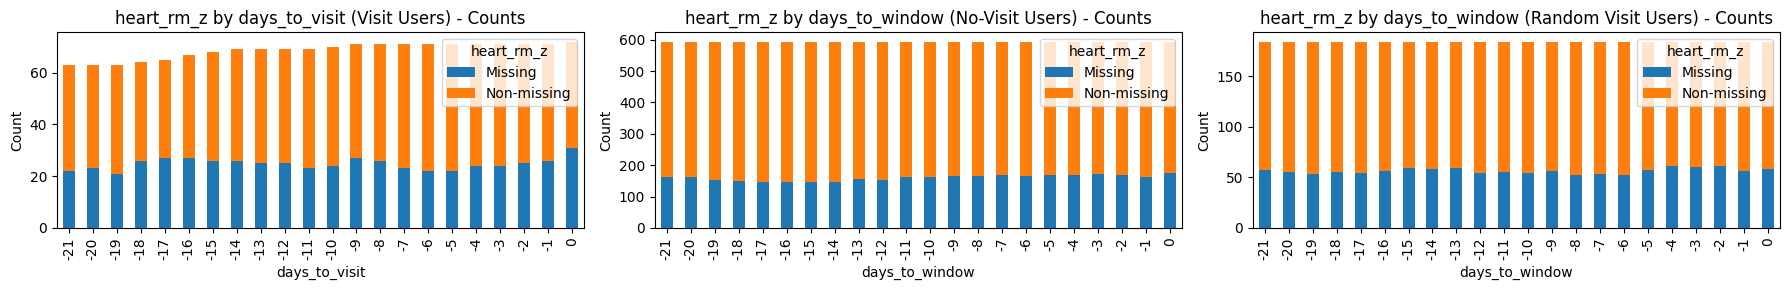

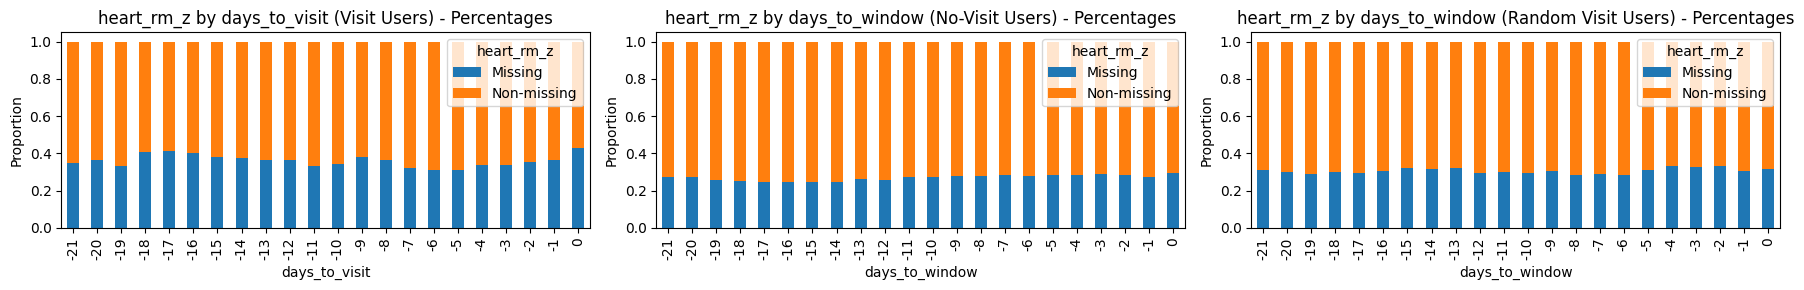

In [78]:
plot_feature_comparison_3(visit_3wk, no_visit_3wk, random_visit_3wk, 'heart_rm_z', bin_continuous=True)

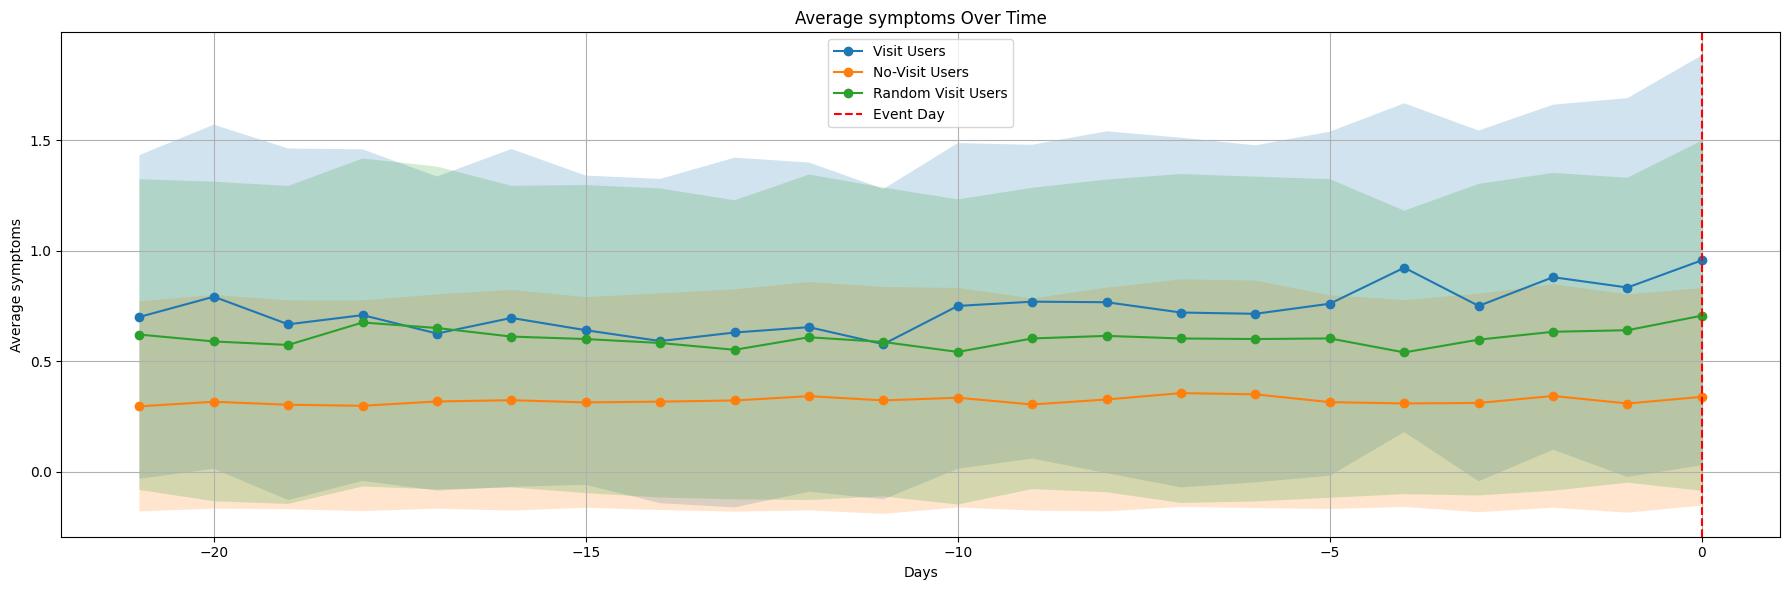

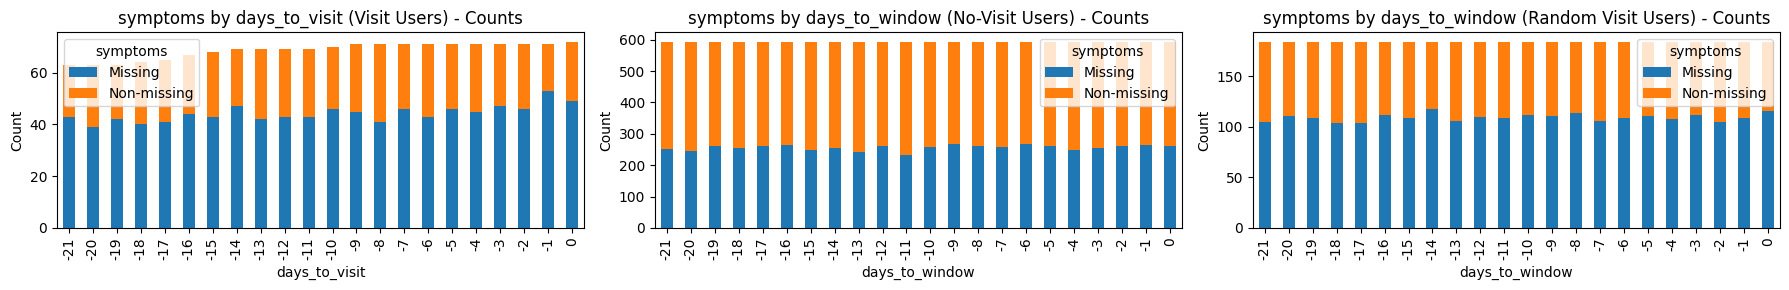

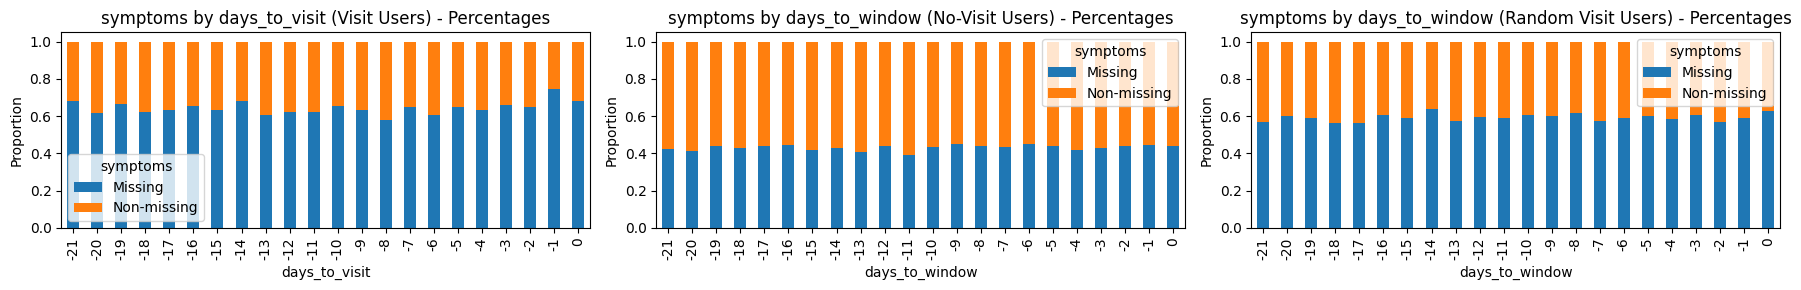

In [79]:
plot_feature_comparison_3(visit_3wk, no_visit_3wk, random_visit_3wk, 'symptoms', bin_continuous=True)

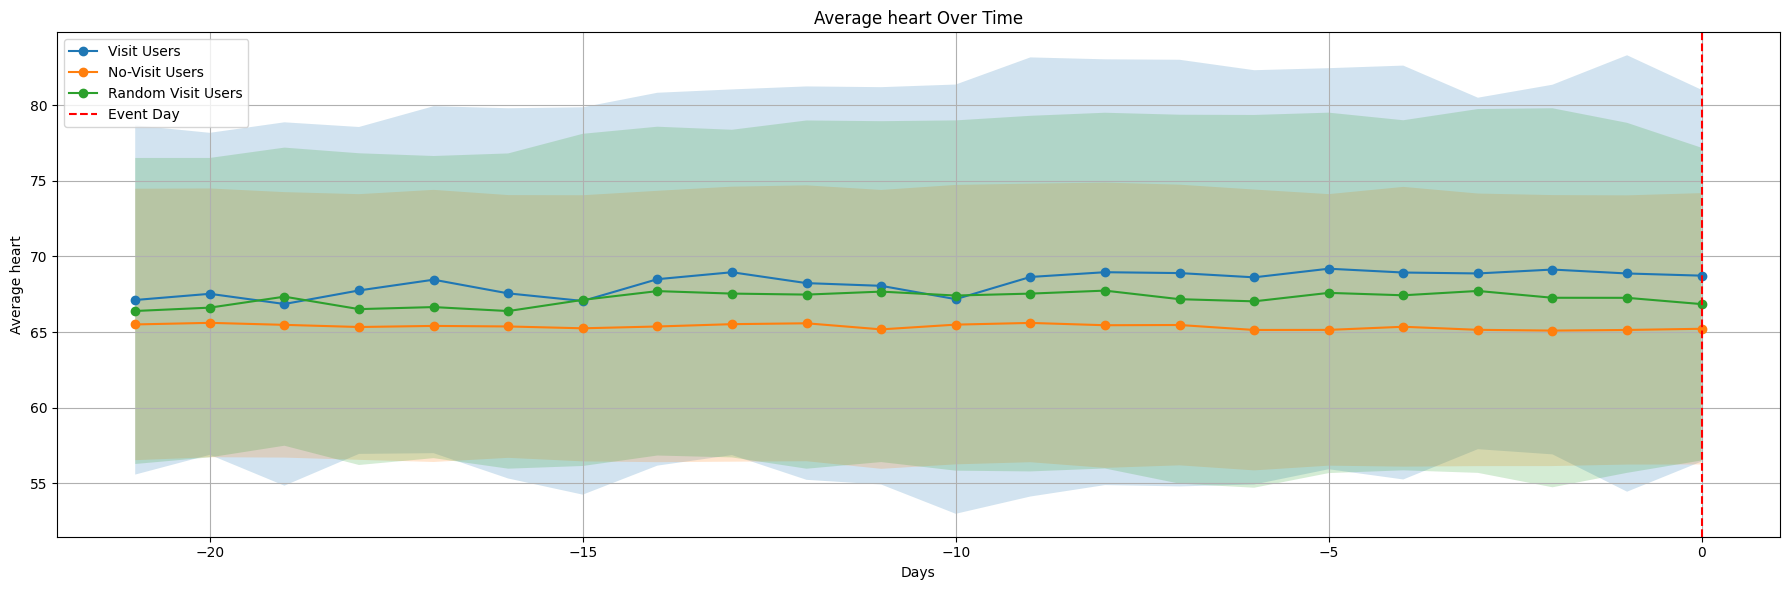

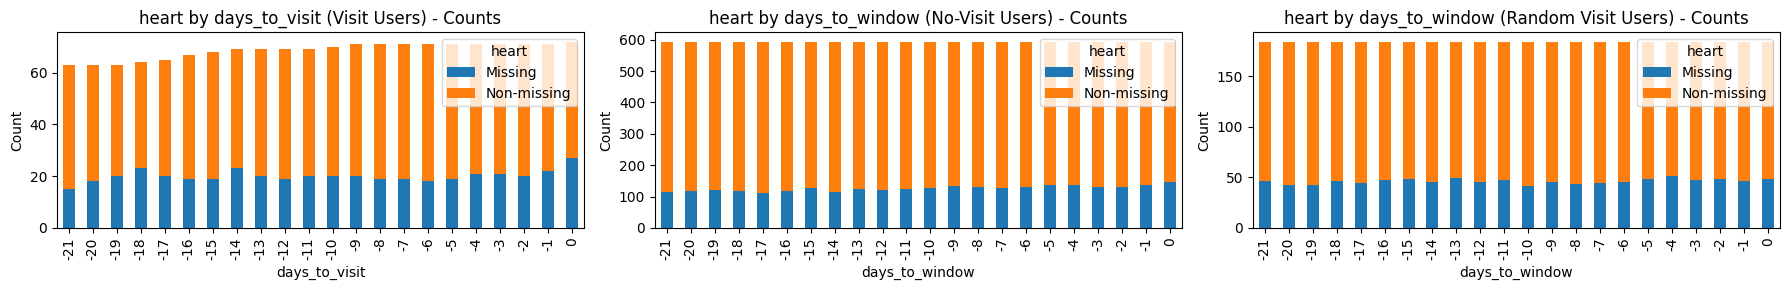

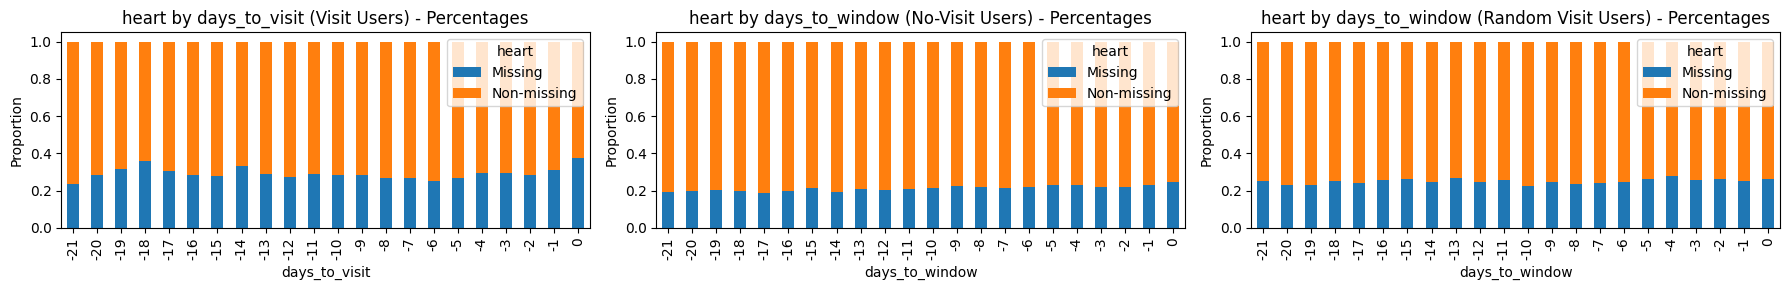

In [80]:
plot_feature_comparison_3(visit_3wk, no_visit_3wk, random_visit_3wk, 'heart', bin_continuous=True)